<a href="https://www.kaggle.com/code/trevorglenn/dog-breed-eda?scriptVersionId=180150931" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-breeds-ranking-best-to-worst/dogs-ranking-dataset.csv


Doing some exploratory data analysis using visualizations, then build a new column called total cost that is the sum of purchase price, lifetime cost, and the product of food cost per year times average longevity. This new column will then influence another new column labeled total cost per year that measures total cost divided by average longevity. We may also build a regression model to predict total cost per year, using solely non-cost variables.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression, SGDRegressor
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('/kaggle/input/dog-breeds-ranking-best-to-worst/dogs-ranking-dataset.csv')

In [4]:
df.head()

,Breed,type,score,popularity ranking,size,intelligence,congential ailments,score for kids,size.1,$LIFETIME COST,INTELLIGENCE RANK,INTELLIGENCE %,LONGEVITY(YEARS),NUMBER OF GENETIC AILMENTS,GENETIC AILMENTS,PURCHASE PRICE,FOOD COSTS PER YEAR,GROOMING FREQUNCY,SUITABILITY FOR CHILDREN
0,Border Terrier,terrier,3.61,61,1,Above average,none,4.99,small,"$22,638",30,70%,14.00,0,none,$833,$324,Once a week,1
1,Cairn Terrier,terrier,3.53,48,1,Above average,"'lion jaw', heart problems",4.91,small,"$21,992",35,61%,13.84,2,"'lion jaw', heart problems",$435,$324,Once a week,1
2,Siberian Husky,working,3.22,16,2,Average,none,4.72,medium,"$22,049",45,45%,12.58,0,none,$650,$466,Once in a few weeks,1
3,Welsh Springer Spaniel,sporting,3.34,81,2,Above average,hip problems,4.71,medium,"$20,224",31,69%,12.49,1,hip problems,$750,$324,Once a week,1
4,English Cocker Spaniel,sporting,3.33,51,2,Excellent,none,4.70,medium,"$18,993",18,82%,11.66,0,none,$800,$324,Once a week,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Breed                       87 non-null     object 
 1   type                        87 non-null     object 
 2   score                       87 non-null     float64
 3   popularity ranking          87 non-null     int64  
 4   size                        87 non-null     int64  
 5   intelligence                87 non-null     object 
 6   congential ailments         87 non-null     object 
 7   score for kids              87 non-null     float64
 8   size.1                      87 non-null     object 
 9   $LIFETIME COST              87 non-null     object 
 10  INTELLIGENCE RANK           87 non-null     int64  
 11  INTELLIGENCE %              87 non-null     object 
 12  LONGEVITY(YEARS)            87 non-null     float64
 13  NUMBER OF GENETIC AILMENTS  87 non-nu

In [6]:
df.describe()

,score,popularity ranking,size,score for kids,INTELLIGENCE RANK,LONGEVITY(YEARS),NUMBER OF GENETIC AILMENTS,SUITABILITY FOR CHILDREN
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,2.603678,44.000000,1.954023,3.681839,41.540230,11.117701,1.689655,1.540230
std,0.570288,25.258662,0.819927,0.655736,21.979803,1.938465,1.707101,0.678655
min,0.990000,1.000000,1.000000,1.860000,1.000000,6.290000,0.000000,1.000000
25%,2.185000,22.500000,1.000000,3.180000,27.000000,10.000000,0.500000,1.000000
50%,2.710000,44.000000,2.000000,3.810000,43.000000,11.560000,1.000000,1.000000
75%,3.035000,65.500000,3.000000,4.115000,59.000000,12.430000,2.000000,2.000000
max,3.640000,87.000000,3.000000,4.990000,80.000000,16.500000,9.000000,3.000000


For our numerical columns we have: score, popularity ranking, size, score for kids, INTELLIGENCE RANK, LONGEVITY(YEARS), NUMBER OF GENETIC AILMENTS, SUITABILITY FOR CHILDREN

We would want our columns to have a similar format so let's first change our columns that are in all-caps to lower case

In [7]:
print(df.columns[9:].values)

['$LIFETIME COST' 'INTELLIGENCE RANK' 'INTELLIGENCE %' 'LONGEVITY(YEARS)'
 'NUMBER OF GENETIC AILMENTS' 'GENETIC AILMENTS' 'PURCHASE PRICE'
 'FOOD COSTS PER YEAR' 'GROOMING FREQUNCY' 'SUITABILITY FOR CHILDREN']


All-caps columns = 
$LIFETIME COST,
INTELLIGENCE RANK,
INTELLIGENCE %,
LONGEVITY(YEARS),
NUMBER OF GENETIC AILMENTS,
GENETIC AILMENTS,
PURCHASE PRICE,
FOOD COSTS PER YEAR,
GROOMING FREQUNCY,
SUITABILITY FOR CHILDREN

In [8]:
df.columns = [column.lower() for column in df.columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   breed                       87 non-null     object 
 1   type                        87 non-null     object 
 2   score                       87 non-null     float64
 3   popularity ranking          87 non-null     int64  
 4   size                        87 non-null     int64  
 5   intelligence                87 non-null     object 
 6   congential ailments         87 non-null     object 
 7   score for kids              87 non-null     float64
 8   size.1                      87 non-null     object 
 9   $lifetime cost              87 non-null     object 
 10  intelligence rank           87 non-null     int64  
 11  intelligence %              87 non-null     object 
 12  longevity(years)            87 non-null     float64
 13  number of genetic ailments  87 non-nu

Now that's taken care lets scope some of our data, we want to first get an idea of the dog breeds and types included in the list. Then we can scope some of our columns that are not immediately recognizeable such as size.1, grooming frequncy(need to fix spelling here), and congenital ailments.

In [10]:
df.rename(columns={'grooming frequncy': 'grooming frequency'}, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   breed                       87 non-null     object 
 1   type                        87 non-null     object 
 2   score                       87 non-null     float64
 3   popularity ranking          87 non-null     int64  
 4   size                        87 non-null     int64  
 5   intelligence                87 non-null     object 
 6   congential ailments         87 non-null     object 
 7   score for kids              87 non-null     float64
 8   size.1                      87 non-null     object 
 9   $lifetime cost              87 non-null     object 
 10  intelligence rank           87 non-null     int64  
 11  intelligence %              87 non-null     object 
 12  longevity(years)            87 non-null     float64
 13  number of genetic ailments  87 non-nu

In [12]:
df['breed'].unique()

array(['Border Terrier', 'Cairn Terrier', 'Siberian Husky',
       'Welsh Springer Spaniel', 'English Cocker Spaniel',
       'Cocker Spaniel', 'Lhasa Apso', 'English Springer Spaniel',
       'Shetland Sheepdog', 'West Highland White Terrier', 'Brittany',
       'German Shorthaired Pointer', 'Pointer', 'Tibetan Spaniel',
       'Labrador Retriever', 'Bichon Frise', 'Irish Setter', 'Samoyed',
       'Shih Tzu', 'Golden Retriever', 'Chesapeake Bay Retriever',
       'Papillon', 'Gordon Setter', 'English Setter', 'Pug',
       'Affenpinscher', 'Miniature Schnauzer', 'Beagle', 'Border Collie',
       'Australian Terrier', 'Whippet', 'Boston Terrier', 'Briard',
       'Bedlington Terrier', 'Cavalier King Charles Spaniel', 'Dalmatian',
       'Flat-Coated Retriever', 'Belgian Tervuren', 'Basset Hound',
       'Poodle', 'Staffordshire Bull Terrier', 'Bouvier des Flandres',
       'Pembroke Welsh Corgi', 'Clumber Spaniel', 'Pomeranian',
       'Australian Shepherd', 'Pharaoh Hound', 'Dandie D

In [13]:
df['breed'].nunique()

87

In [14]:
df['type'].unique()

array(['terrier', 'working', 'sporting', 'non-sporting', 'herding', 'toy',
       'hound'], dtype=object)

In [15]:
df['type'].nunique()

7

In [16]:
dog_types = df['type'].value_counts()

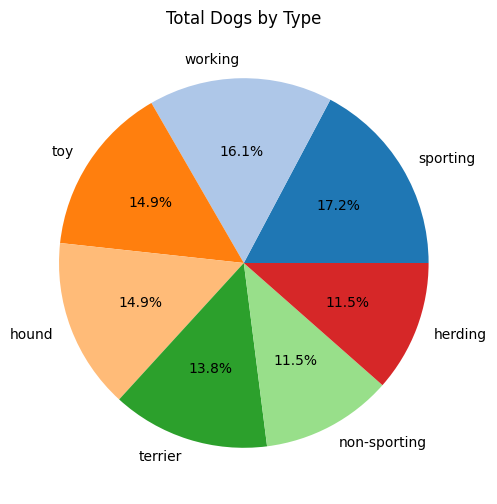

In [17]:
plt.figure(figsize=(6, 6))
plt.pie(dog_types, labels=dog_types.index, autopct='%1.1f%%', colors=plt.cm.tab20.colors)
plt.title('Total Dogs by Type')
plt.show()

Our dog types are relatively equal proportionally. 

In [18]:
df['size'].nunique()

3

In [19]:
total_size = df['size'].value_counts()

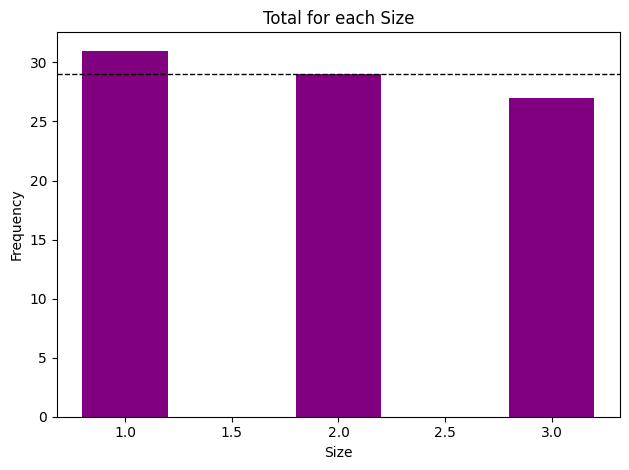

In [20]:
plt.bar(total_size.index, total_size.values, color='purple', width=0.4)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.axhline(y=29, color='black', linestyle='--', linewidth=1)
plt.title('Total for each Size')
plt.tight_layout()
plt.show()

In [21]:
print(total_size)

size
1    31
2    29
3    27
Name: count, dtype: int64


We have 31 small dogs, 29 medium dogs, and 27 large dogs

In [22]:
df['size.1'].nunique()

3

In [23]:
df['size.1'].unique()

array(['small', 'medium', 'large'], dtype=object)

Size.1 seems to be the key for the size column - duplicated info so one would need to be dropped for our model. I think size.1 is actually a better column to keep than as it is more clear in the data recorded.

In [24]:
df['intelligence rank'].nunique()

67

In [25]:
df['intelligence rank'].unique()

array([30, 35, 45, 31, 18, 20, 68, 13,  6, 47, 19, 17, 43, 46,  7, 33, 70,
        4, 27,  8, 34, 37, 57, 12, 73,  1, 51, 54, 40, 44, 39, 14, 71,  2,
       49, 29, 11, 23, 42, 62, 10, 56, 67,  5, 79, 80, 63, 58, 22, 48, 59,
       28,  9, 41, 65, 69,  3, 72, 60, 74, 52, 66, 76, 50, 75, 77, 78])

Our intelligence ranking only has 67 unique values for 87 dog breeds

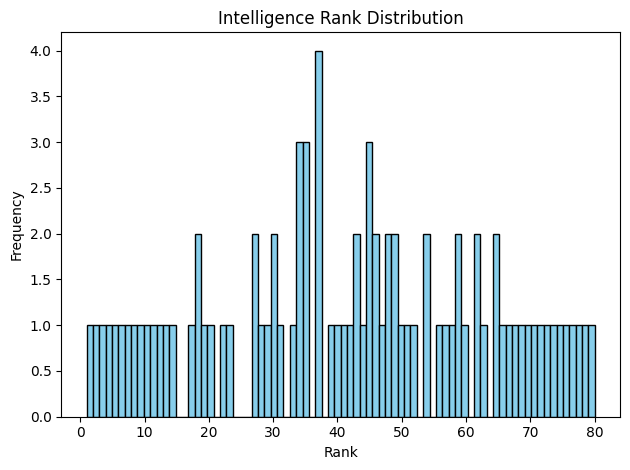

In [26]:
plt.hist(df['intelligence rank'], bins=80, color='skyblue', edgecolor='black')
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Intelligence Rank Distribution")
plt.tight_layout()
plt.show()

In [27]:
print(df['intelligence %'])

0     70%
1     61%
2     45%
3     69%
4     82%
     ... 
82    36%
83     7%
84     5%
85    31%
86     3%
Name: intelligence %, Length: 87, dtype: object


We have numerous breeds with the same rank of intelligence, and after a quick scoping of intelligence percent we need to drop the percent symbol to be able to graph it and see if there is at least some added differentiation.

In [28]:
df['intelligence %'] = df['intelligence %'].str.replace('%', '').astype(int)

In [29]:
print(df['intelligence %'])

0     70
1     61
2     45
3     69
4     82
      ..
82    36
83     7
84     5
85    31
86     3
Name: intelligence %, Length: 87, dtype: int64


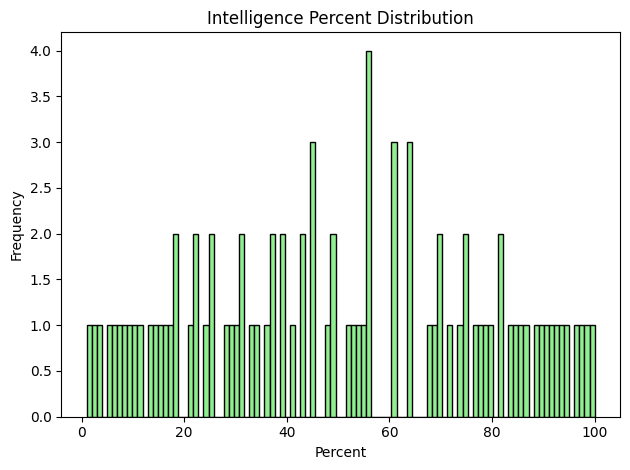

In [30]:
plt.hist(df['intelligence %'], bins=100, color='lightgreen', edgecolor='black')
plt.xlabel("Percent")
plt.ylabel("Frequency")
plt.title("Intelligence Percent Distribution")
plt.tight_layout()
plt.show()

Intelligence % has the same issue as intelligence rank where we have multiple breeds with the same recorded intelligence. While possible, this also could be slightly inaccurate and cause confusion for our model. May consider tuning this data if we want to include it in our model especially if our initial model score is not as good as we would like.

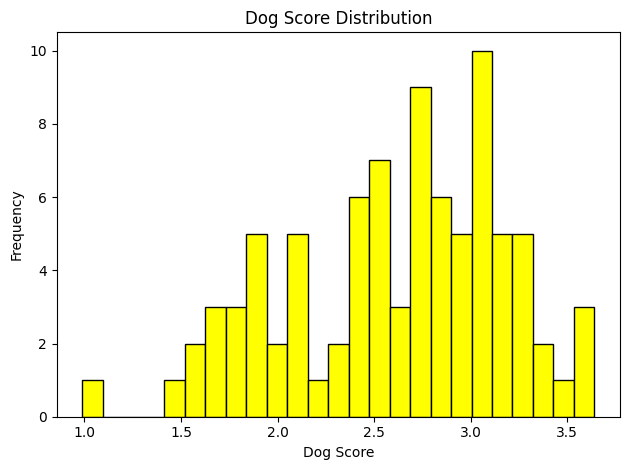

In [31]:
plt.hist(df['score'], bins=25, color='yellow', edgecolor='black')
plt.xlabel("Dog Score")
plt.ylabel("Frequency")
plt.title("Dog Score Distribution")
plt.tight_layout()
plt.show()

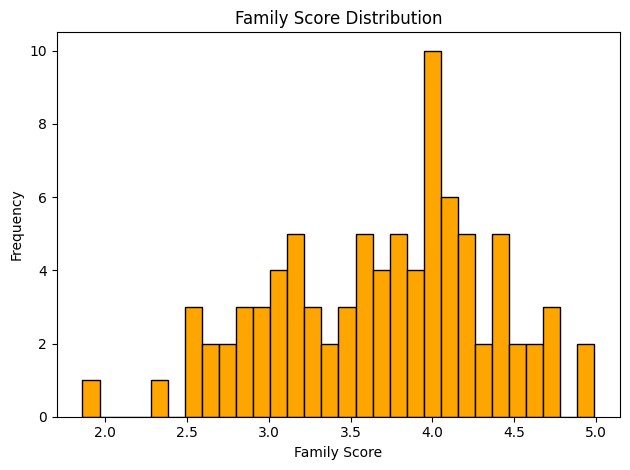

In [32]:
plt.hist(df['score for kids'], bins=30, color='orange', edgecolor='black')
plt.xlabel("Family Score")
plt.ylabel("Frequency")
plt.title("Family Score Distribution")
plt.tight_layout()
plt.show()

Dog score and Kid Score have slightly similar distributions. Neither are quite normal and may need to normalized for model input.

Family score of 4 has a very high frequency compared to the rest of our distribution, lets look at all breeds with a family score around 4.

In [33]:
familyscoreisfour = df[(df['score for kids'] >= 3.95) & (df['score for kids'] <= 4.05)]

In [34]:
print("Number of gog breeds with a family score around 4: ", familyscoreisfour['breed'].nunique())
print("Dog breeds with a family score around 4:")
print(familyscoreisfour['breed'])

Number of gog breeds with a family score around 4:  10
Dog breeds with a family score around 4:
27                           Beagle
28                    Border Collie
29               Australian Terrier
30                          Whippet
31                   Boston Terrier
32                           Briard
33               Bedlington Terrier
34    Cavalier King Charles Spaniel
35                        Dalmatian
36            Flat-Coated Retriever
Name: breed, dtype: object


Lets see if our lowest/highest of score and family score are the same breed.

In [35]:
lowest_score_index = df['score'].idxmin()
lowest_score_breed = df.loc[lowest_score_index, 'breed']
print("Breed with the lowest score:", lowest_score_breed)

Breed with the lowest score: Bulldog


In [36]:
lowest_familyscore_index = df['score for kids'].idxmin()
lowest_familyscore_breed = df.loc[lowest_familyscore_index, 'breed']
print("Breed with the lowest family score:", lowest_familyscore_breed)

Breed with the lowest family score: Bulldog


Bulldogs have the lowest score and family score

In [37]:
highest_score_index = df['score'].idxmax()
highest_score_breed = df.loc[highest_score_index, 'breed']
print("Breed with the highest score:", highest_score_breed)

Breed with the highest score: Border Collie


In [38]:
highest_familyscore_index = df['score for kids'].idxmax()
highest_familyscore_breed = df.loc[highest_familyscore_index, 'breed']
print("Breed with the lowest family score:", highest_familyscore_breed)

Breed with the lowest family score: Border Terrier


There is a slight difference in our highest score and highest family scores: Border Collie has highest score, but Border Terrier has the highest family score.

Let's take a look at suitability for children, which is a more specified criteria strictly for the dog around children than the family score.

In [39]:
kid_suitability = df['suitability for children'].value_counts()

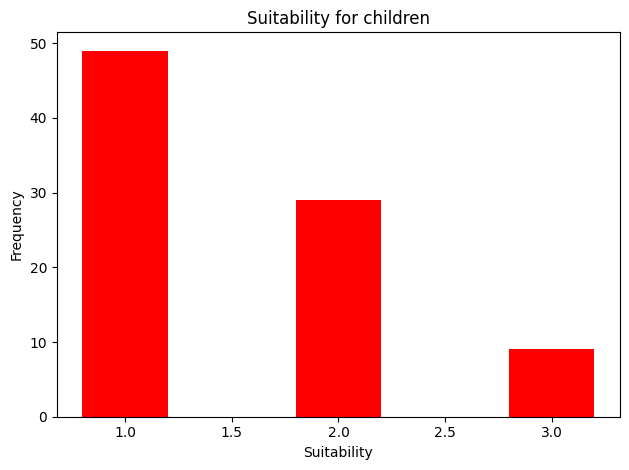

In [40]:
plt.bar(kid_suitability.index, kid_suitability.values, color='red', width=0.4)
plt.xlabel('Suitability')
plt.ylabel('Frequency')
plt.title('Suitability for children')
plt.tight_layout()
plt.show()

 (1 = high suitability, 2= medium suitability, 3= low suitability)

In [41]:
low_kid_suitability = df[df['suitability for children'] == 3.0]

In [42]:
low_kid_suitability_breeds = low_kid_suitability['breed']
print("Total Number of low suitability breeds: ", low_kid_suitability_breeds.nunique())
print(low_kid_suitability_breeds)

Total Number of low suitability breeds:  9
28            Border Collie
50    Australian Cattle Dog
53                Dachshund
54                Chihuahua
64         Brussels Griffon
65                  Maltese
68        Yorkshire Terrier
76        Italian Greyhound
85                    Akita
Name: breed, dtype: object


Border Collie, interestingly, has a low suitability for children but a relatively high family score and the highest overall score

In [43]:
low_kid_suitability_types = low_kid_suitability['type']
print(low_kid_suitability_types)

28    herding
50    herding
53      hound
54        toy
64        toy
65        toy
68        toy
76        toy
85    working
Name: type, dtype: object


In [44]:
high_kid_suitability = df[df['suitability for children'] == 1.0]

In [45]:
high_suitability_types = high_kid_suitability['type'].value_counts()

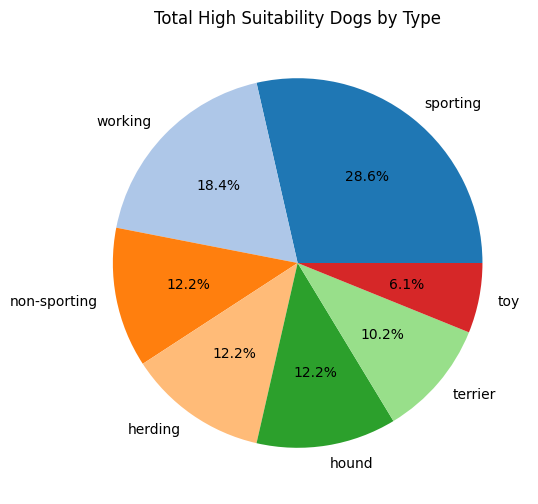

In [46]:
plt.figure(figsize=(6, 6))
plt.pie(high_suitability_types, labels=high_suitability_types.index, autopct='%1.1f%%', colors=plt.cm.tab20.colors)
plt.title('Total High Suitability Dogs by Type')
plt.show()

If you wanted a dog more suitable for children you'd likely look for a Sporting or Working dog.

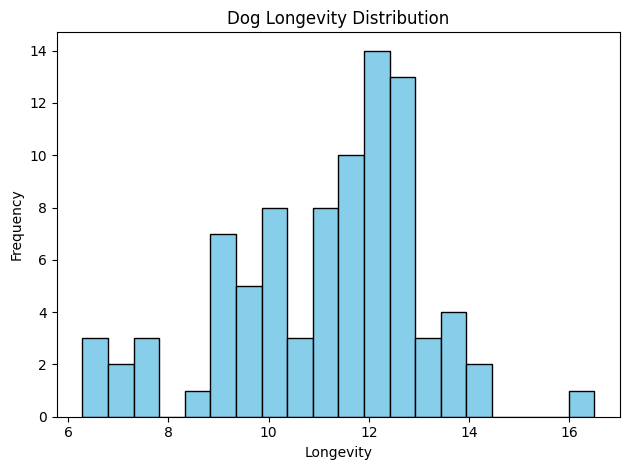

In [47]:
plt.hist(df['longevity(years)'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Longevity")
plt.ylabel("Frequency")
plt.title("Dog Longevity Distribution")
plt.tight_layout()
plt.show()

Majority dogs have a longevity between 9 and 14 years, lets set up an IQR to get a better picture of this and find our outliers

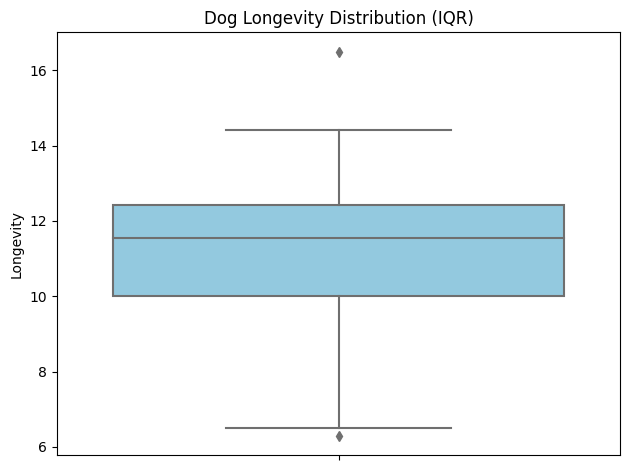

In [48]:
sns.boxplot(y=df['longevity(years)'], color='skyblue')
plt.ylabel("Longevity")
plt.title("Dog Longevity Distribution (IQR)")
plt.tight_layout()
plt.show()

Our IQR is 10 years to about 12.5 years, we have two outliers: one at around 6 years and one at around 16.5 years. Let's do some more scoping on this column to learn about our outliers. 

In [49]:
df['longevity(years)'].max()

16.5

In [50]:
df['longevity(years)'].min()

6.29

In [51]:
Q1 = df['longevity(years)'].quantile(0.25)
Q3 = df['longevity(years)'].quantile(0.75)
IQR = Q3 - Q1

outliers = (df['longevity(years)'] < (Q1 - 1.5 * IQR)) | (df['longevity(years)'] > (Q3 + 1.5 * IQR))

outlier_breeds = df.loc[outliers, 'breed']
print("Outlier breeds:")
print(outlier_breeds)

Outlier breeds:
54    Chihuahua
86      Bulldog
Name: breed, dtype: object


Chihuahas live the longest, and Bulldogs the shortest on average.

In [52]:
print("Q1 ends at: ", Q1, "/","Q3 starts at: ", Q3)
print("IQR is: ", Q1, "to", Q3, "years")

Q1 ends at:  10.0 / Q3 starts at:  12.43
IQR is:  10.0 to 12.43 years


Lets look at some breeds within our inner quartile range that also have a high suitability for children.

In [53]:
within_iqr_with_high_suitability = df[(df['longevity(years)'] >= Q1) & 
                                             (df['longevity(years)'] <= Q3) & 
                                             (df['suitability for children'] == 1.0)]

In [54]:
print(within_iqr_with_high_suitability['breed'])

4            English Cocker Spaniel
11       German Shorthaired Pointer
12                          Pointer
14               Labrador Retriever
15                     Bichon Frise
16                     Irish Setter
19                 Golden Retriever
22                    Gordon Setter
23                   English Setter
24                              Pug
27                           Beagle
31                   Boston Terrier
32                           Briard
34    Cavalier King Charles Spaniel
35                        Dalmatian
37                 Belgian Tervuren
38                     Basset Hound
40       Staffordshire Bull Terrier
41             Bouvier des Flandres
42             Pembroke Welsh Corgi
43                  Clumber Spaniel
47           Dandie Dinmont Terrier
49                           Saluki
59                     Afghan Hound
60             Old English Sheepdog
Name: breed, dtype: object


These are the dogs within our inner quartile of longevity and are suitable for children

Finally lets look at some of our costs before we start feature engineering. We have three cost columns: purchase price, food cost per year, and $lifetime cost. Let's rename lifetime cost so that is has better readability.

In [55]:
df.rename(columns={'$lifetime cost': 'lifetime cost'}, inplace=True)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   breed                       87 non-null     object 
 1   type                        87 non-null     object 
 2   score                       87 non-null     float64
 3   popularity ranking          87 non-null     int64  
 4   size                        87 non-null     int64  
 5   intelligence                87 non-null     object 
 6   congential ailments         87 non-null     object 
 7   score for kids              87 non-null     float64
 8   size.1                      87 non-null     object 
 9   lifetime cost               87 non-null     object 
 10  intelligence rank           87 non-null     int64  
 11  intelligence %              87 non-null     int64  
 12  longevity(years)            87 non-null     float64
 13  number of genetic ailments  87 non-nu

In [57]:
df['lifetime cost'] = df['lifetime cost'].astype(str).str.replace('$', '')
df['lifetime cost'] = df['lifetime cost'].astype(str).str.replace(' ', '')
df['lifetime cost'] = df['lifetime cost'].astype(str).str.replace(',', '')
df['lifetime cost'] = df['lifetime cost'].astype(int)

In [58]:
df['lifetime cost'].unique()

array([22638, 21992, 22049, 20224, 18993, 24330, 22031, 21946, 21006,
       20490, 22589, 25842, 24445, 25549, 21299, 19735, 20323, 25352,
       21152, 21447, 16697, 21001, 19605, 20312, 18527, 18333, 20087,
       19468, 20143, 17892, 20976, 17741, 19673, 22107, 18639, 19886,
       16000, 19132, 18328, 21237, 21650, 18959, 23978, 18084, 15792,
       21458, 21047, 21633, 15819, 24866, 20395, 20336, 24308, 20113,
       26250, 18397, 17521, 19351, 22096, 24077, 22611, 17266, 16099,
       15746, 19551, 19084, 26686, 18886, 20701, 18435, 17525, 13936,
       17416, 13581, 14662, 17240, 16463, 20565, 16530, 18490, 20022,
       16176, 21986, 13824, 15898, 20994, 13479])

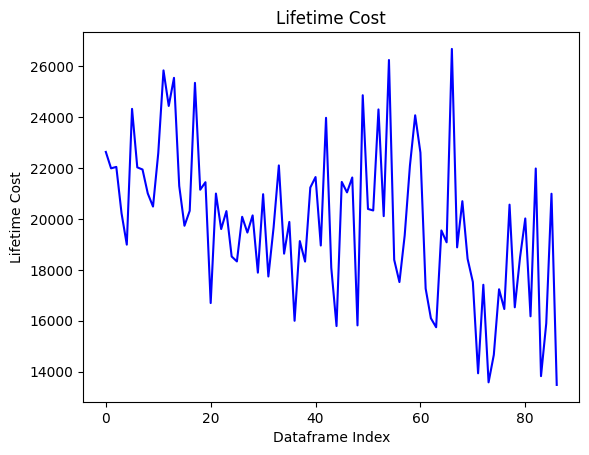

In [59]:
plt.plot(df['lifetime cost'], color='blue')
plt.xlabel('Dataframe Index')
plt.ylabel('Lifetime Cost')
plt.title('Lifetime Cost')

plt.show()

This line plot simply measures our lifetime cost by index of dataframe entry, we may come back to this later to improve insights gained from graph but I'm going to leave it for now.

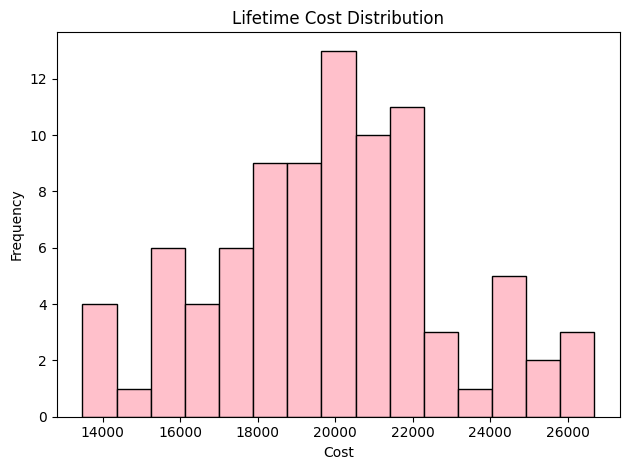

In [60]:
plt.hist(df['lifetime cost'], bins=15, color='pink', edgecolor='black')
plt.xlabel("Cost")
plt.ylabel("Frequency")
plt.title("Lifetime Cost Distribution")
plt.tight_layout()
plt.show()

Relatively normal distribution for lifetime costs.

In [61]:
df['purchase price'].unique()

array(['$833 ', '$435 ', '$650 ', '$750 ', '$800 ', '$465 ', '$350 ',
       '$615 ', '$538 ', '$618 ', '$545 ', '$294 ', '$1,050 ', '$810 ',
       '$693 ', '$525 ', '$1,162 ', '$583 ', '$958 ', '$522 ', '$740 ',
       '$700 ', '$469 ', '$510 ', '$715 ', '$288 ', '$623 ', '$640 ',
       '$915 ', '$690 ', '$1,058 ', '$1,017 ', '$695 ', '$600 ',
       '$1,070 ', '$490 ', '$900 ', '$1,145 ', '$1,335 ', '$587 ',
       '$1,033 ', '$670 ', '$565 ', '$913 ', '$925 ', '$1,175 ',
       '$1,525 ', '$530 ', '$1,140 ', '$2,083 ', '$423 ', '$588 ',
       '$790 ', '$1,178 ', '$940 ', '$890 ', '$832 ', '$1,900 ',
       '$1,320 ', '$1,118 ', '$1,057 ', '$1,333 ', '$829 ', '$980 ',
       '$820 ', '$1,040 ', '$1,200 ', '$885 ', '$995 ', '$1,085 ',
       '$875 ', '$675 ', '$1,210 ', '$608 ', '$515 ', '$1,202 ',
       '$2,680 '], dtype=object)

In [62]:
df['purchase price'].nunique()

77

In [63]:
df['purchase price'] = df['purchase price'].astype(str).str.replace('$', '')
df['purchase price'] = df['purchase price'].astype(str).str.replace(' ', '')
df['purchase price'] = df['purchase price'].astype(str).str.replace(',', '')
df['purchase price'] = df['purchase price'].astype(int)

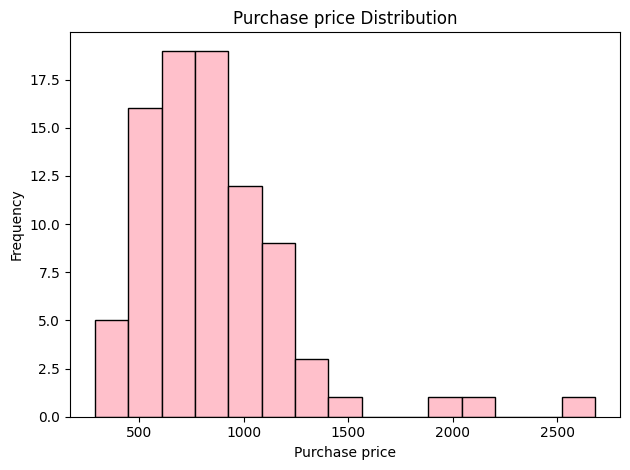

In [64]:
plt.hist(df['purchase price'], bins=15, color='pink', edgecolor='black')
plt.xlabel("Purchase price")
plt.ylabel("Frequency")
plt.title("Purchase price Distribution")
plt.tight_layout()
plt.show()

Purchase Price is skewed right.

In [65]:
df['food costs per year'].unique()

array(['$324 ', '$466 ', '$674 ', '$405 ', '$971 ', '$710 ', '$270 ',
       '$1,349 ', '$1,217 ', '$701 '], dtype=object)

In [66]:
df['food costs per year'].nunique()

10

In [67]:
df['food costs per year'] = df['food costs per year'].astype(str).str.replace('$', '')
df['food costs per year'] = df['food costs per year'].astype(str).str.replace(' ', '')
df['food costs per year'] = df['food costs per year'].astype(str).str.replace(',', '')
df['food costs per year'] = df['food costs per year'].astype(int)

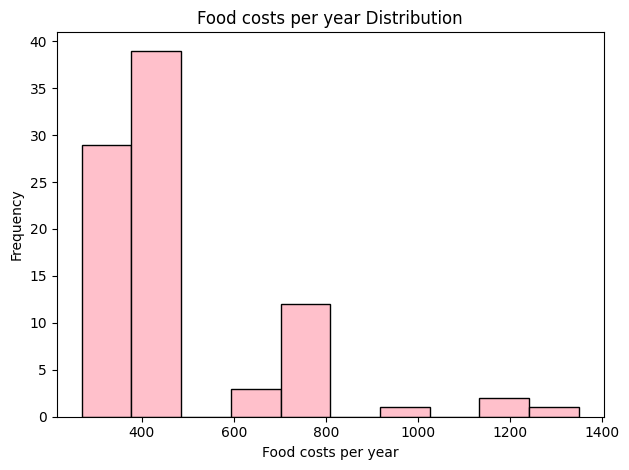

In [68]:
plt.hist(df['food costs per year'], bins=10, color='pink', edgecolor='black')
plt.xlabel("Food costs per year")
plt.ylabel("Frequency")
plt.title("Food costs per year Distribution")
plt.tight_layout()
plt.show()

Food costs per year is also skewed right and with only 7 unique costs we might be better served looking at this via bar graph instead of histogram

In [69]:
food_costs = df['food costs per year'].value_counts().sort_index()

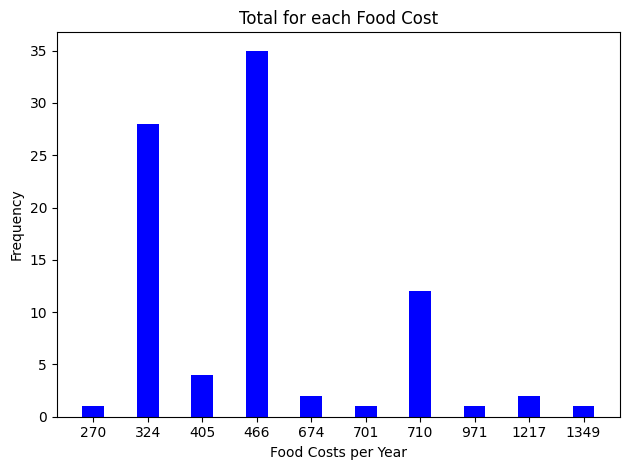

In [70]:
plt.bar(food_costs.index.astype(str), food_costs.values, color='blue', width=0.4)
plt.xlabel('Food Costs per Year')
plt.ylabel('Frequency')
plt.title('Total for each Food Cost')
plt.tight_layout()
plt.show()

Our food costs per year is dominated by 324, 466, and 710 - these three dollar amounts encompass about 75 of our 87 breeds

Now for our feature engineering

In [71]:
df['total food cost'] = df['longevity(years)'] * df['food costs per year']

In [72]:
df['total food cost'].head()

0    4536.00
1    4484.16
2    5862.28
3    4046.76
4    3777.84
Name: total food cost, dtype: float64

In [73]:
df['total cost'] = df['lifetime cost'] + df['purchase price'] + df['total food cost']

In [74]:
df['total cost'].head()

0    28007.00
1    26911.16
2    28561.28
3    25020.76
4    23570.84
Name: total cost, dtype: float64

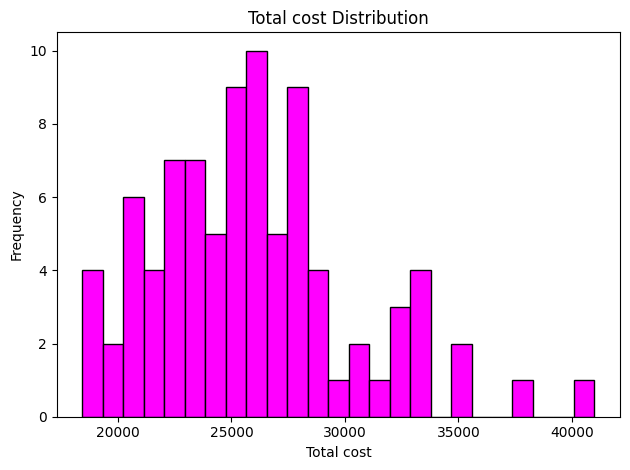

In [75]:
plt.hist(df['total cost'], bins=25, color='magenta', edgecolor='black')
plt.xlabel("Total cost")
plt.ylabel("Frequency")
plt.title("Total cost Distribution")
plt.tight_layout()
plt.show()

Close to a normal distribution but still skewed a little bit to the right. We also have one clear outlier over 40,000 USD that is our maximum total cost. Let's do an IQR to see if we have another outlier as well.

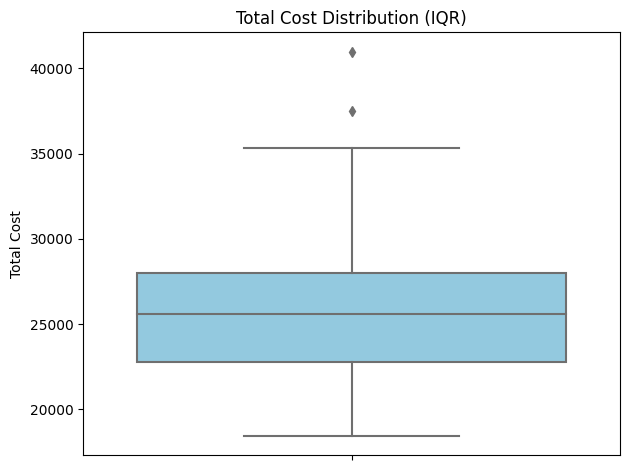

In [76]:
sns.boxplot(y=df['total cost'], color='skyblue')
plt.ylabel("Total Cost")
plt.title("Total Cost Distribution (IQR)")
plt.tight_layout()
plt.show()

Both outliers are above our upper quartile, which ends just about 35,000 USD. Let's see which breeds they are. 

In [77]:
Q1 = df['total cost'].quantile(0.25)
Q3 = df['total cost'].quantile(0.75)
IQR = Q3 - Q1

outliers = (df['total cost'] < (Q1 - 1.5 * IQR)) | (df['total cost'] > (Q3 + 1.5 * IQR))

outlier_breeds = df.loc[outliers, 'breed']
print("Outlier breeds:")
print(outlier_breeds)

Outlier breeds:
11    German Shorthaired Pointer
66               Giant Schnauzer
Name: breed, dtype: object


Our two most expensive breeds are: German Shorthaired Pointer and Giant Schnauzer

**Cheers! Next I want to build a model to predict total cost based solely on non-cost factors in our dataset (since our model could easily just solve this mathematically if we include the cost columns). Come back later if you want to see how that turns out!**